# Imports

In [1]:
import os
import sys
sys.path.append(os.path.realpath(".."))

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from evlp_bronch.dataset import ALL_LUNG_IDS, RawEVLPDataset, ProcessedEVLPDataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init

import numpy as np
import tqdm as tqdm
from scipy.stats import pearsonr


# Device Setup

In [2]:
device = torch.device("cuda")
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Load Data

In [3]:
train_lung_ids, test_lung_ids = train_test_split(
    ALL_LUNG_IDS, test_size=2, random_state=1
)
train_lung_ids, val_lung_ids = train_test_split(
    train_lung_ids, test_size=2, random_state=1
)

train_dataset = ProcessedEVLPDataset(train_lung_ids)
val_dataset = ProcessedEVLPDataset(val_lung_ids)
test_dataset = ProcessedEVLPDataset(test_lung_ids)

2023-12-02 23:19:06,677 - evlp_bronch.dataset - INFO - Lung_id 29: Interpolation Dy_comp: between 329 and 331: 142.764474, 157.684626
2023-12-02 23:19:06,731 - evlp_bronch.dataset - INFO - Lung_id 47: Interpolation Dy_comp: between 51 and 56: 50.582276, 72.674668
2023-12-02 23:19:06,754 - evlp_bronch.dataset - INFO - Lung_id 53: Interpolation Dy_comp: between 2813 and 2824: 60.586801, 106.632301


In [4]:
len(train_dataset), len(val_dataset), len(test_dataset)

(143, 7, 4)

# Data Visualization

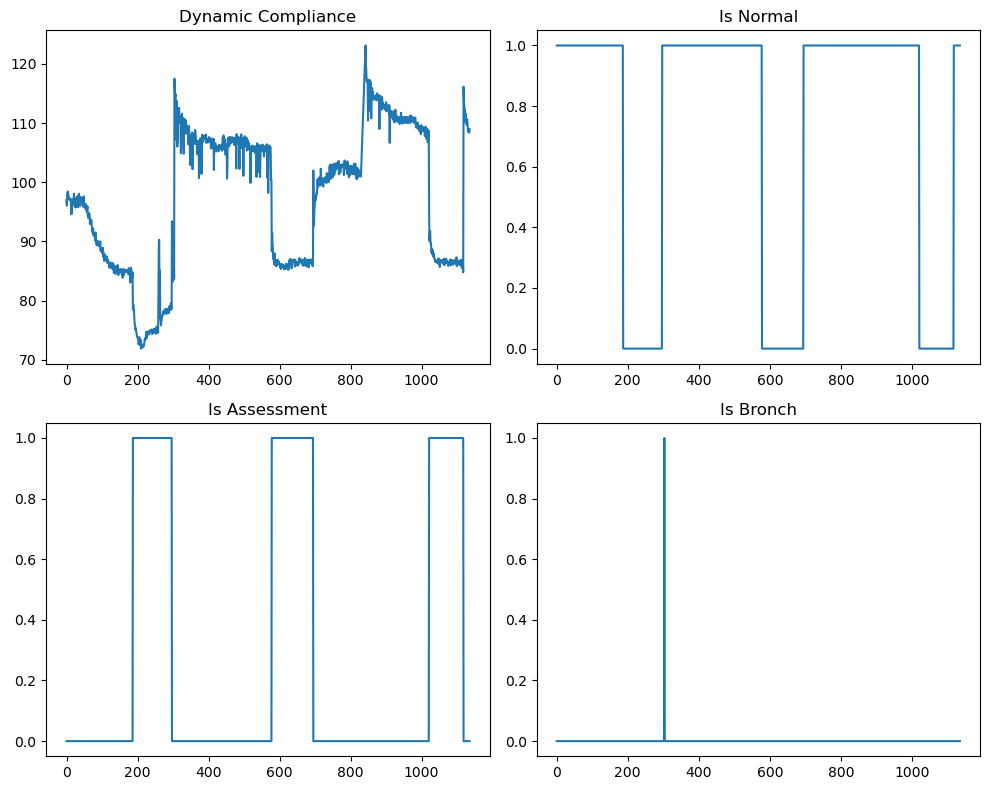

In [5]:
a = test_dataset[2]['Dy_comp']
c = test_dataset[2]['Is_normal']
b = test_dataset[2]['Is_assessment']
d = test_dataset[2]['Is_bronch']

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.title('Dynamic Compliance')
plt.plot(a)

plt.subplot(2, 2, 2)
plt.title('Is Normal')
plt.plot(c)

plt.subplot(2, 2, 3)
plt.title('Is Assessment')
plt.plot(b)

plt.subplot(2, 2, 4)
plt.title('Is Bronch')
plt.plot(d)

plt.tight_layout()

# Utils Functions

In [6]:
def find_last(lst, value): # find the last occurence of a value in a list
    lst.reverse()
    i = lst.index(value)
    lst.reverse()
    return len(lst) - i - 1

In [7]:
def right_pad_sequence(sequence, target_length):
    current_length = len(sequence)
    total_padding = target_length - current_length
    if total_padding <= 0:
        return sequence
    pad_after = total_padding

    return np.pad(sequence, (0, pad_after), mode='edge')
len(right_pad_sequence(train_dataset[0]['Dy_comp'][:1+1], 1415))


1415

In [8]:
def find_max_length_x():
    m = [0,0,0]
    for i in train_dataset:
        metric_start = find_last(list(i['Is_bronch']), 1) # find the last bronch
        if metric_start > m[0]:
            m[0]=metric_start+1
    for i in val_dataset:
        metric_start = find_last(list(i['Is_bronch']), 1) # find the last bronch
        if metric_start > m[1]:
            m[1]=metric_start+1
    for i in test_dataset:
        metric_start = find_last(list(i['Is_bronch']), 1) # find the last bronch
        if metric_start > m[2]:
            m[2]=metric_start+1
    return max(m)
max_l = find_max_length_x()
max_l

1416

In [9]:
def find_max_length_y(dataset):
    m = 0
    for i in dataset:
        metric_start = find_last(list(i['Is_bronch']), 1) # find the last bronch
        changes = np.where(np.diff(i['Is_assessment']) == 1)[0]  # Find where each assessment period begins
        # Find the first assessment period that starts after the last bronch occurrence
        first_assessment_after_bronch = None
        for change in changes:
            if change > metric_start:
                first_assessment_after_bronch = change
                break
        if metric_start< (len(i['Is_assessment']) - 1) * 0:
            continue
        if first_assessment_after_bronch is None:
            first_assessment_after_bronch = len(i['Is_assessment']) - 1
        if len(i['Dy_comp'][metric_start:first_assessment_after_bronch]) == 0: # if bronch紧接着assessment
            continue
        if len(i['Dy_comp'][metric_start:first_assessment_after_bronch]) > m:
            m = first_assessment_after_bronch - metric_start
    return m + 1
max_y_train = find_max_length_y(train_dataset)
max_y_val = find_max_length_y(val_dataset)
max_y_test = find_max_length_y(test_dataset)
max_y = max(max_y_train, max_y_val, max_y_test)
max_y

368

In [10]:
def set_dataset(dataset):
    X_dc = []
    X_is_normal = []
    X_is_bronch = []

    Y = []
    Y_len = []

    for i in dataset:
        metric_start = find_last(list(i['Is_bronch']), 1) # find the last bronch
        changes = np.where(np.diff(i['Is_assessment']) == 1)[0]  # Find where each assessment period begins
        # Find the first assessment period that starts after the last bronch occurrence
        first_assessment_after_bronch = None
        for change in changes:
            if change > metric_start:
                first_assessment_after_bronch = change
                break
        if metric_start< (len(i['Is_assessment']) - 1) * 0:
            continue

        if first_assessment_after_bronch is None:
            first_assessment_after_bronch = len(i['Is_assessment']) - 1
        if len(i['Dy_comp'][metric_start:first_assessment_after_bronch]) == 0: # if bronch紧接着assessment
            continue

        # 做padding，保证长度一致，用最长的长度
        X_dc.append(right_pad_sequence(i['Dy_comp'][:metric_start+1], max_l))
        X_is_normal.append(right_pad_sequence(i['Is_normal'][:metric_start+1], max_l))
        X_is_bronch.append(right_pad_sequence(i['Is_bronch'][:metric_start+1], max_l))

        Y_len.append(len(i['Dy_comp'][metric_start:first_assessment_after_bronch])) # 记录长度，用于计算loss)
        Y.append(right_pad_sequence(i['Dy_comp'][metric_start:first_assessment_after_bronch], max_y))

    print(f"length is {len(X_dc)}")    
    assert len(X_dc) == len(X_is_bronch) == len(X_is_normal) == len(Y), "Inconsistent number of samples"

    X_dc = np.array(X_dc).reshape(-1, max_l)
    X_is_normal = np.array(X_is_normal).reshape(-1, max_l)
    X_is_bronch = np.array(X_is_bronch).reshape(-1, max_l)
    Y = torch.from_numpy(np.array(Y)).float()
    Y_len = torch.from_numpy(np.array(Y_len)).int()

    X_combined = np.stack([X_dc, X_is_normal, X_is_bronch], axis=1)  # Shape becomes [N, 3, 1470]
    X_combined = torch.from_numpy(X_combined).float()

    return X_combined, Y, Y_len



# Set Dataset

In [11]:
class EVLPDataset(Dataset):
    def __init__(self, X_combined, Y, Y_len):
        self.X_combined = X_combined
        self.Y = Y
        self.Y_len = Y_len

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X_combined[idx], self.Y[idx], self.Y_len[idx]

In [12]:
x_combine_train, y_train, y_len_train = set_dataset(train_dataset)
x_combine_val, y_val, y_len_val = set_dataset(val_dataset)
x_combine_test, y_test, y_len_test = set_dataset(test_dataset)

train_loader = DataLoader(EVLPDataset(x_combine_train, y_train, y_len_train), batch_size=32, shuffle=True)
val_loader = DataLoader(EVLPDataset(x_combine_val, y_val, y_len_val), batch_size=1, shuffle=False)
test_loader = DataLoader(EVLPDataset(x_combine_test, y_test, y_len_test), batch_size=1, shuffle=False)


length is 143
length is 7
length is 4


# PyTorch

In [13]:
def train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs):
    model.train()
    epoch_losses = []  # List to store average training loss per epoch
    val_losses = []    # List to store average validation loss per epoch

    val_target = []
    val_predict = []

    for epoch in range(epochs):
        running_loss = 0.0

        for inputs, y, lengths in train_loader:
            inputs, y = inputs.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            mask = torch.arange(outputs.size(1)).expand(len(lengths), outputs.size(1)) < lengths.unsqueeze(1)
            mask = mask.to(device)
            outputs_masked = torch.masked_select(outputs, mask).to(device)
            y_masked = torch.masked_select(y, mask).to(device)

            loss = criterion(outputs_masked, y_masked)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
        average_loss = running_loss / len(train_loader)
        epoch_losses.append(average_loss)

        model.eval()
        with torch.no_grad():
            running_val_loss = 0.0
            for inputs, y, lengths in val_loader:
                inputs, y = inputs.to(device), y.to(device)
                outputs = model(inputs)

                mask = torch.arange(outputs.size(1)).expand(len(lengths), outputs.size(1)) < lengths.unsqueeze(1)
                mask = mask.to(device)
                outputs_masked = torch.masked_select(outputs, mask).to(device)
                y_masked = torch.masked_select(y, mask).to(device)

                loss = criterion(outputs_masked, y_masked)

                val_loss = criterion(outputs_masked, y_masked)
            
                if epoch == epochs - 1:
                    val_target.append(y[:, :lengths])
                    val_predict.append(outputs[:, :lengths])
    
                running_val_loss += val_loss.item()

            average_val_loss = running_val_loss / len(val_loader)
            val_losses.append(average_val_loss)

        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch + 1}, Training Loss: {average_loss}, Validation Loss: {average_val_loss}")

        if epoch == epochs - 1:
            # Flatten the validation target and prediction lists
            flat_val_target = torch.cat([t.flatten() for t in val_target])
            flat_val_predict = torch.cat([p.flatten() for p in val_predict])

            # Calculate Pearson's R
            pearson_r, _ = pearsonr(flat_val_target.cpu().numpy(), flat_val_predict.cpu().numpy())
            print(f"Epoch {epoch + 1}, Pearson's R: {pearson_r}")

        model.train()

    # Determine the number of rows and columns for subplots
    num_samples = len(val_predict)
    cols = 2
    rows = num_samples // cols + (num_samples % cols > 0)

    # Plotting
    plt.figure(figsize=(12, 4 * rows))
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        plt.plot(val_predict[i][0].cpu().numpy(), label='Predicted')
        plt.plot(val_target[i][0].cpu().numpy(), label='Target', alpha=0.7)
        plt.title(f"Sample {i+1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Values")
        plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(range(1, epochs+1), epoch_losses, marker='o', color='blue', label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, marker='o', color='red', label='Validation Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()

    model.eval()

    output_ls = []
    target_ls = []

    test_loss = 0
    with torch.no_grad():
        for data, y, lengths in test_loader:
            data, y = data.to(device), y.to(device)
            outputs = model(data)
            
            mask = torch.arange(outputs.size(1)).expand(len(lengths), outputs.size(1)) < lengths.unsqueeze(1)
            mask = mask.to(device)
            outputs_masked = torch.masked_select(outputs, mask).to(device)
            y_masked = torch.masked_select(y, mask).to(device)

            output_ls.append(outputs[:, :lengths])
            target_ls.append(y[:, :lengths])

            case_loss = criterion(outputs_masked, y_masked).item()
            test_loss += case_loss

    test_loss /= len(test_loader.dataset)

    # Flatten the test target and prediction lists
    flat_test_target = torch.cat([t.flatten() for t in target_ls])
    flat_test_predict = torch.cat([p.flatten() for p in output_ls])
    pearson_r, _ = pearsonr(flat_test_target.cpu().numpy(), flat_test_predict.cpu().numpy())

    # Determine the number of rows and columns for subplots
    num_samples = len(output_ls)
    cols = 2
    rows = num_samples // cols + (num_samples % cols > 0)

    # Plotting
    plt.figure(figsize=(12, 4 * rows))
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        plt.plot(output_ls[i][0].cpu().numpy(), label='Predicted')
        plt.plot(target_ls[i][0].cpu().numpy(), label='Target', alpha=0.7)
        plt.title(f"Sample {i+1}")
        plt.xlabel("Time Steps")
        plt.ylabel("Values")
        plt.legend()

    plt.tight_layout()
    plt.show()

    print(f'Test set: Average loss: {test_loss:.4f}, Pearson\'s R: {pearson_r}')

In [14]:
class CNN(nn.Module):
    def __init__(self, kernel=3, num_filters=64, num_in_channels=3, padding=0):
        super().__init__()

        self.conv1 = torch.nn.Conv1d(num_in_channels, num_filters, kernel_size=kernel, padding=padding)
        self.conv1.weight.data.uniform_(0, 0.01)
        self.conv2 = nn.Conv1d(num_filters, 128, kernel_size=kernel, padding=padding)
        self.conv2.weight.data.uniform_(0, 0.01)

        self.conv_seq = nn.Sequential(
            self.conv1,
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            self.conv2,
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        conv_output_size = self._calculate_conv_output_size(max_l, kernel, padding)
        self.fc1 = torch.nn.Linear(conv_output_size, 128)
        init.uniform_(self.fc1.weight, -0.01, 0.01)

        self.fc_seq = torch.nn.Sequential( 
            self.fc1,
            torch.nn.ReLU()
        )

        self.final_layer = nn.Linear(in_features=128, out_features=max_y)
        init.uniform_(self.final_layer.weight, -0.01, 0.01)

    def _calculate_conv_output_size(self, input_length, kernel, padding):
        size = (input_length - kernel + 2 * padding) + 1
        size = size // 2
        size = (size - kernel + 2 * padding) + 1
        size = size // 2
        return size * 128  
    
    def forward(self, x):
        x = self.conv_seq(x)
        x = x.view(x.size(0), -1)
        x = self.fc_seq(x)
        x = self.final_layer(x)
        return x

## Performance Comparison

Epoch 20, Training Loss: 254.77448120117188, Validation Loss: 303.6617640086583
Epoch 40, Training Loss: 242.2169982910156, Validation Loss: 247.96824598312378
Epoch 60, Training Loss: 246.617578125, Validation Loss: 364.87221499851773
Epoch 80, Training Loss: 163.18314208984376, Validation Loss: 297.10611626080106
Epoch 100, Training Loss: 184.3365692138672, Validation Loss: 259.9127129146031
Epoch 120, Training Loss: 169.73827056884767, Validation Loss: 247.79203823634558
Epoch 140, Training Loss: 171.0946258544922, Validation Loss: 244.42104176112585
Epoch 160, Training Loss: 206.33963317871093, Validation Loss: 378.2968967982701
Epoch 180, Training Loss: 182.36461486816407, Validation Loss: 251.60261004311698
Epoch 200, Training Loss: 256.1716110229492, Validation Loss: 258.8706512451172
Epoch 200, Pearson's R: 0.6816347706112713


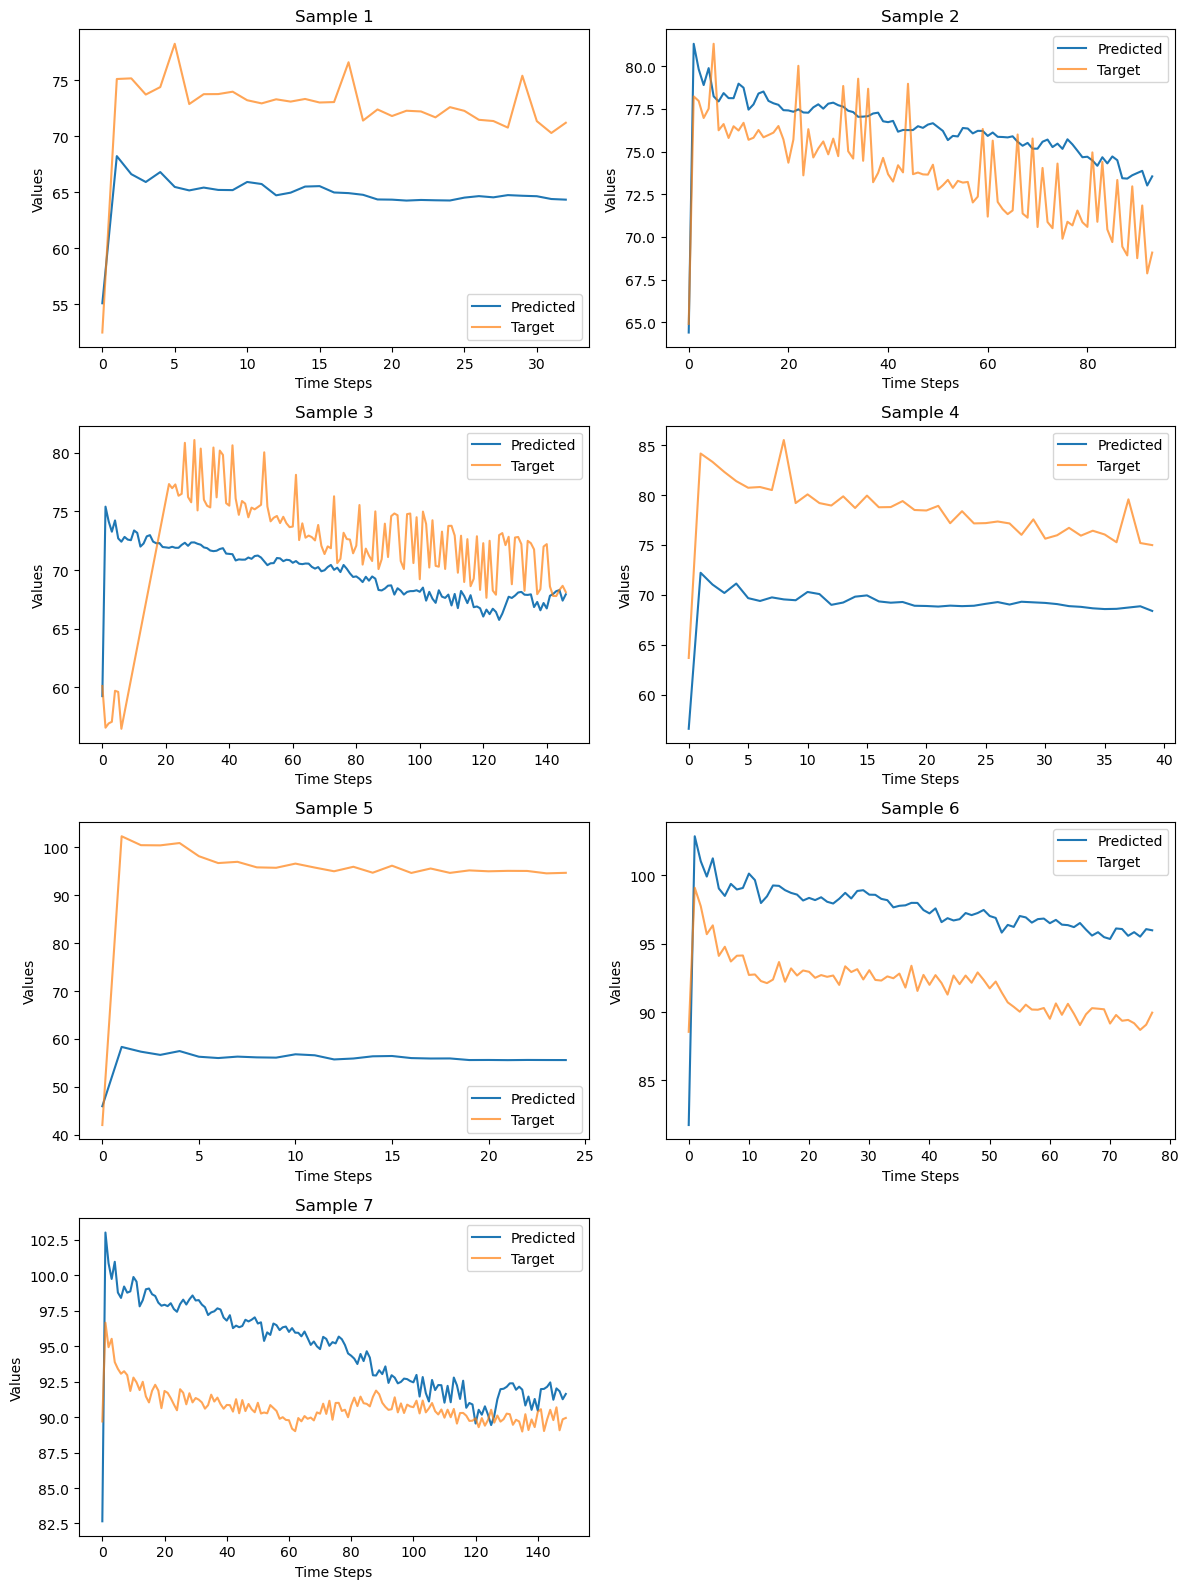

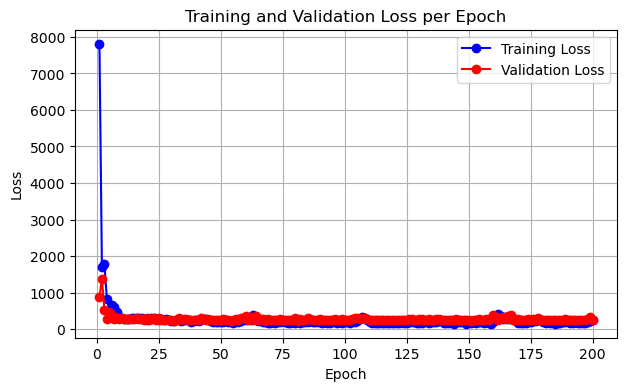

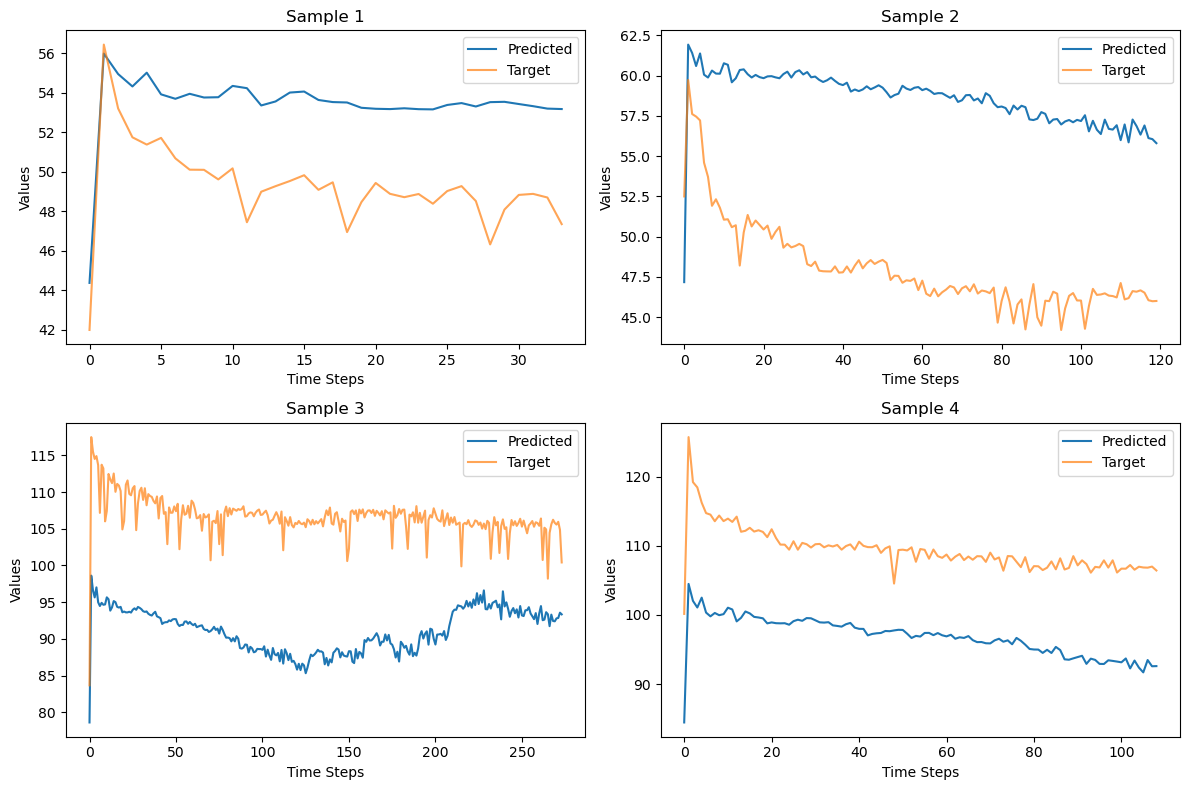

Test set: Average loss: 136.9813, Pearson's R: 0.9820100992750984


In [16]:
epochs = 200
model = CNN(kernel=3, num_filters=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.000001, betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
criterion = nn.MSELoss()

train(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs)